# D-Score Suite (v1) Benchmark -- Usage Examples


:::{note}
_This notebook adapted from originals by Timothy Hodson and Rich Signell. See that upstream work at:_
* https://github.com/thodson-usgs/dscore
* https://github.com/USGS-python/hytest-evaluation-workflows/
:::

This notebook will demonstrate how to call the specific functions defined in the D-Score Suite
notebook, using a small demonstration dataset.

In [1]:
import pandas as pd
import numpy as np

## Sample Data

In [2]:
sampleData = pd.read_csv(r"../nwm_streamflow/NWM_Benchmark_SampleData.csv", index_col='date', parse_dates=True).dropna()
print(len(sampleData.index), " Records")

12145  Records


A quick look at the table shows that this data contains time-series streamflow values for
observed ('obs'), the NWM data model ('nwm'), and the NHM model ('nhm').  This demonstration
dataset limits to a single gage ("`site_no` = 1104200")

In [3]:
sampleData.head()

,site_no,obs,nwm,nhm
date,,,,
1983-10-01,1104200,1.121347,6.175417,1.469472
1983-10-02,1104200,1.214793,6.250417,1.848861
1983-10-03,1104200,0.872159,6.215833,2.169456
1983-10-04,1104200,0.419089,6.105000,2.200083
1983-10-05,1104200,0.849505,5.952500,1.931588


## Import Benchmark Functions
The metric functions are defined and described in
{doc}`evaluation/Metrics_DScore_Suite_v1`.
They are imported here by running that notebook from within the following cell:

In [5]:
%run ../../Metrics_DScore_Suite_v1.ipynb
# This defines the same functions in this notebook's namespace.

The functions are now available here, to run against our sample data:

In [6]:
# Mean Square Error
mse(sampleData['obs'], sampleData['nwm'])

55.73589185136414

In [15]:
seasonal_mse(sampleData['obs'], sampleData['nwm'])

winter    13.205368
spring    11.135375
summer    14.120221
fall      17.274927
dtype: float64

## Create Composite Benchmark
It is useful to combine several of these metrics into a single benchmark routine, which returns a pandas Series of the assembled metrics.

This 'wrapper' composite benchmark also handles any transforms of the data before calling the metric functions. In this case, we will log transform the data. 

In [22]:
def compute_benchmark(df):
    """
    Runs several metrics against the data table in 'df'.  

    NOTE: the 'obs' and 'nwm' columns must exist in df, and that nan's have already been removed.  
    """
    obs = np.log(df['obs'].clip(lower=0.01)) # clip to remove zeros and negative values
    sim = np.log(df['nwm'].clip(lower=0.01)) 
    
    mse_ = pd.Series(
        [ mse(obs, sim) ], 
        index=["mse"], 
        dtype='float32'
    )
    return pd.concat([
            mse_,
            bias_distribution_sequence(obs, sim), 
            seasonal_mse(obs, sim),
            quantile_mse(obs, sim)
            ],
        )

In [23]:
compute_benchmark(sampleData)

mse          0.874842
e_bias       0.409683
e_dist       0.224187
e_seq        0.241010
winter       0.057879
spring       0.033822
summer       0.396487
fall         0.386654
low          0.653889
below_avg    0.127766
above_avg    0.052214
high         0.040973
dtype: float64

## Score-Cards
The DScore functions include an ILAMB-style scorecard function to produce a graphic scorecard from these metrics.
Note that a scorecard such as this is typically applied to a composite of DScore metrics computed for many gages.
This demos the scorecard for a single gage **as if** it were the mean of all gages in an evaluation analysis. 

In [25]:
# Compute benchmark and 'score' each decomp as percent of total MSE
bm = compute_benchmark(sampleData)
percentage_card = pd.DataFrame(data={
    'NWM' : ((bm / bm['mse']) * 100).round().astype(int)
    })
percentage_card.name="Percent"  ## NOTE: `name` is a non-standard attribute for a dataframe. We use it to stash
                                ## metadata for this dataframe which the ilamb_card_II() func will use to label things.
percentage_card

,NWM
mse,100
e_bias,47
e_dist,26
e_seq,28
winter,7
spring,4
summer,45
fall,44
low,75
below_avg,15


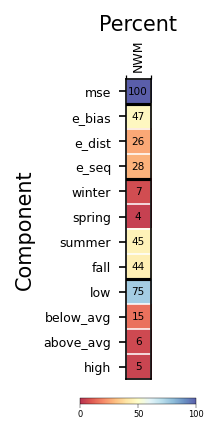

In [27]:
n_cards=1
fig, ax = plt.subplots(1, n_cards, figsize=(0.5+(1.5*n_cards), 3.25), dpi=150)
ax = ilamb_card_II(percentage_card, ax)
plt.show()


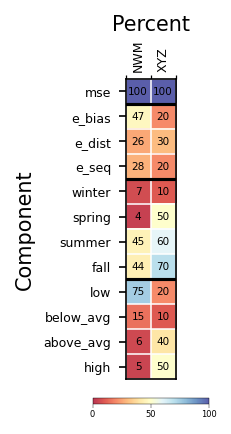

In [28]:
## if the score card has columns for multilple models.....  
# fictitious example:
percentage_card['XYZ'] = pd.Series([100, 20, 30, 20, 10, 50, 60, 70, 20, 10, 40, 50], index=percentage_card.index)
fig, ax = plt.subplots(1, n_cards, figsize=(0.5+(1.5*n_cards), 3.25), dpi=150)
ax = ilamb_card_II(percentage_card, ax)
plt.show()